In [35]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers, optimizers, initializers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import os
import glob
import shutil
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, BatchNormalization, Dense, RandomFlip, RandomTranslation, RandomRotation, GlobalAveragePooling2D, Input, RandomZoom, Rescaling, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [36]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Load dataset with 20% validation split for grayscale images
train_dataset = image_dataset_from_directory(
    directory=train_dir,
    batch_size=32,
    image_size=(224, 224),
    color_mode='rgb',  
    validation_split=0.2,
    subset='training',
    seed=234
)

validation_dataset = image_dataset_from_directory(
    directory=train_dir,
    batch_size=32,
    image_size=(224, 224),
    color_mode='rgb',  
    validation_split=0.2,
    subset='validation',
    seed=234
)

# For testing data (no validation split for testing)
test_dataset = image_dataset_from_directory(
    directory=test_dir,
    batch_size=32,
    image_size=(224, 224),
    color_mode='rgb' 
)

# Check if the dataset loads correctly
class_names = train_dataset.class_names
print(class_names)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


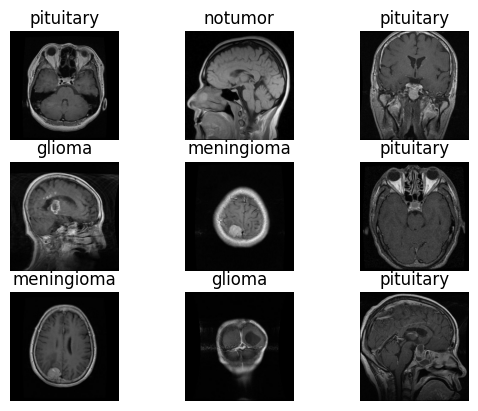

Image shape: (32, 224, 224, 3)
Label shape: (32,)


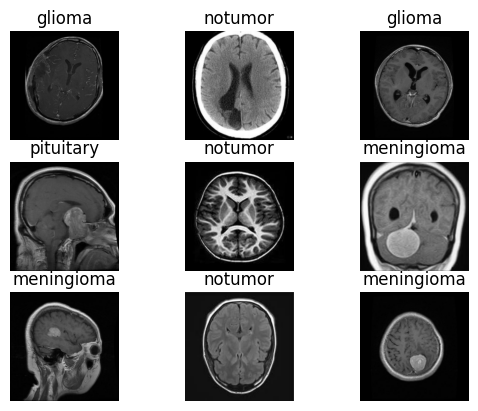

Image shape: (32, 224, 224, 3)
Label shape: (32,)


In [37]:
# Function to visualize the images
def visual(image, class_name, number):
    for i in range(number):
        plt.subplot(int(np.sqrt(number)), int(np.sqrt(number)), i + 1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')
    plt.show()

# Number of images to display
number = 9

# Use the class names from the train_dataset
class_name = train_dataset.class_names

# Visualize some images from the training set
for image, label in train_dataset.take(1):
    visual(image, class_name, number)
    img_shape = image.shape
    lab_shape = label.shape

# Print the shape of the images and labels from the training set
print(f"Image shape: {img_shape}")
print(f"Label shape: {lab_shape}")

# Visualize some images from the validation set
for image, label in validation_dataset.take(1):
    visual(image, class_name, number)
    img_shape = image.shape
    lab_shape = label.shape

# Print the shape of the images and labels from the validation set
print(f"Image shape: {img_shape}")
print(f"Label shape: {lab_shape}")


['glioma', 'meningioma', 'notumor', 'pituitary']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


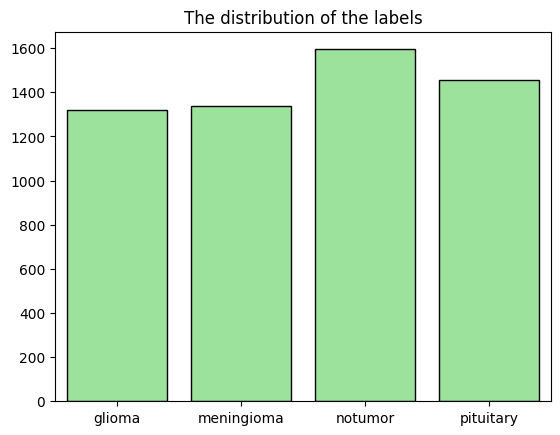

1321
1339
1595
1457


In [38]:
def counter(path):
    c = 0
    for p in os.scandir(path):
        if p.is_file():
            c += 1
    return c

print(class_name)

glioma_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/glioma'
meningioma_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'
notumor_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/notumor'
pituitary_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'

glioma_count = counter(glioma_path)
meningioma_count = counter(meningioma_path)
notumor_count = counter(notumor_path)
pituitary_count = counter(pituitary_path)

sn.barplot(x=class_name, y=[glioma_count, meningioma_count, notumor_count, pituitary_count], color='lightgreen', edgecolor='black')
plt.title("The distribution of the labels")
plt.show()

print(glioma_count)
print(meningioma_count)
print(notumor_count)
print(pituitary_count)

In [39]:
# Data augmentation function
def augment_images(image, label):
    # Normalize image to [0, 1]
    image = image / 255.0
    # Apply augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast
    return image, label

# Apply data augmentation to training dataset
train_dataset = train_dataset.map(augment_images)

# Prefetch for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax

def create_model():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal(),
               input_shape=(224, 224, 3)),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        #BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        #BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        #BatchNormalization(),
        MaxPooling2D((2,2)),
    
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
         #BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',
              kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
        #BatchNormalization(),
        MaxPooling2D((2,2)),
        

        Flatten(),

        Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01),
              kernel_initializer=initializers.he_normal()),
        #BatchNormalization(),
        Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01),
              kernel_initializer=initializers.he_normal()),
        #BatchNormalization(),
        Dense(4, activation="softmax")
    ])

    model.compile(Adamax(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [41]:
model = create_model()

history = model.fit(train_dataset,
          validation_data = validation_dataset,
          epochs=50,  
          verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.4134 - loss: 83.5731 - val_accuracy: 0.6865 - val_loss: 146.2996
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - accuracy: 0.6864 - loss: 61.1619 - val_accuracy: 0.7391 - val_loss: 124.5652
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.7427 - loss: 49.5415 - val_accuracy: 0.7583 - val_loss: 108.6218
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.7642 - loss: 41.9550 - val_accuracy: 0.7846 - val_loss: 116.4215
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.8011 - loss: 36.3979 - val_accuracy: 0.8030 - val_loss: 107.4217
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.8227 - loss: 32.2944 - val_accuracy: 0.8275 - val_loss: 110.9612
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.8345 - loss: 28.9847 - val_accuracy: 0.8529 - val_loss: 80.2418
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accura

In [42]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f'Training Loss: {train_loss:.2f}')
print(f'Training Accuracy: {train_accuracy:.2f}')

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f'Validation Loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy:.2f}')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Testing Loss: {test_loss:.2f}')
print(f'Testing Accuracy: {test_accuracy:.2f}')

143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.9903 - loss: 3.4942
Training Loss: 3.49
Training Accuracy: 0.99
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9438 - loss: 41.6404
Validation Loss: 45.60
Validation Accuracy: 0.95
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9788 - loss: 20.4418
Testing Loss: 23.67
Testing Accuracy: 0.97


In [50]:
# Save the model
model.save('best_model_so_far.keras')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

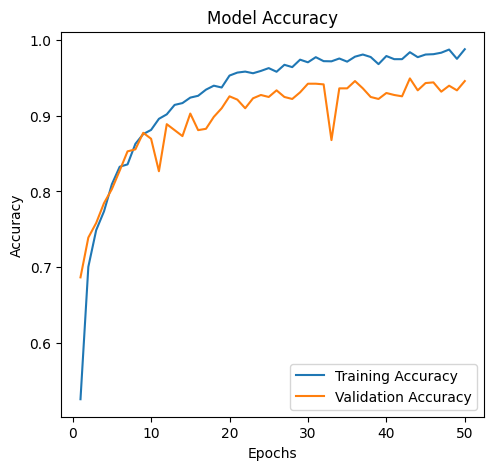

In [44]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sn.lineplot(x=np.arange(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy')
sn.lineplot(x=np.arange(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Model Accuracy")
plt.legend()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

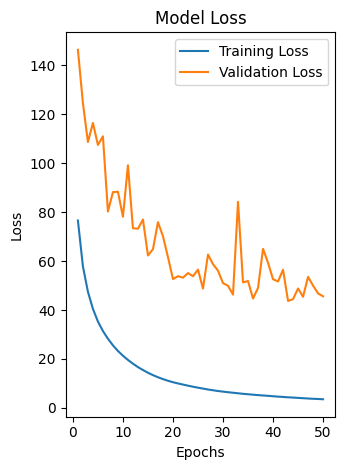

In [45]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
sn.lineplot(x=np.arange(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss')
sn.lineplot(x=np.arange(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Model Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
import tensorflow as tf  # Import TensorFlow to manage logging
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Suppress TensorFlow logging for progress bar
tf.get_logger().setLevel('ERROR')

def load_and_preprocess_image(img_path):
    """Load and preprocess a single image for 224x224x3 color images."""
    img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

def predict_images(model, img_paths, class_names):
    """Predict the class of multiple images at once."""
    img_arrays = np.array([load_and_preprocess_image(img_path) for img_path in img_paths])
    predictions = model.predict(img_arrays, verbose=0)  # Suppress progress bar for predictions
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]
    return predicted_classes

def predict_directory(model, directory_path, class_names, batch_size=32):
    """Predict the classes of all images in a directory and count class-wise predictions."""
    class_count = {class_name: 0 for class_name in class_names}  # Initialize count for each class
    total_images = 0
    img_paths = [os.path.join(directory_path, img_file) for img_file in os.listdir(directory_path)
                 if img_file.endswith(('png', 'jpg', 'jpeg'))]  # List all valid images
    
    for i in range(0, len(img_paths), batch_size):
        batch_paths = img_paths[i:i + batch_size]
        predicted_classes = predict_images(model, batch_paths, class_names)
        
        # Increment counts for predicted classes
        for predicted_class in predicted_classes:
            class_count[predicted_class] += 1
        total_images += len(batch_paths)  # Increment total images count
    
    return class_count, total_images

def main(model_path, directory_path, class_names):
    # Explicitly run the model on GPU if available
    with tf.device('/GPU:0'):  # Forces the use of the first GPU
        model = load_model(model_path)  # Load model from .keras file
        class_count, total_images = predict_directory(model, directory_path, class_names)

    # Print the summary
    print(f"Out of {total_images} images:")
    for class_name, count in class_count.items():
        print(f"- {class_name}: {count}")
    
    return class_count

# Example usage
model_path = '/kaggle/working/final_brain_tumor.keras'  # Path to your saved model
directory_path = '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'  # Path to the directory with images
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Class names


# Call main function to load model, predict, and get summary
class_count = main(model_path, directory_path, class_names)


Num GPUs Available:  1
Out of 1321 images:
- Glioma: 1288
- Meningioma: 30
- No Tumor: 1
- Pituitary: 2


In [47]:
import tensorflow as tf  # Import TensorFlow to manage logging
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Suppress TensorFlow logging for progress bar
tf.get_logger().setLevel('ERROR')

def load_and_preprocess_image(img_path):
    """Load and preprocess a single image for 224x224x3 color images."""
    img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

def predict_images(model, img_paths, class_names):
    """Predict the class of multiple images at once."""
    img_arrays = np.array([load_and_preprocess_image(img_path) for img_path in img_paths])
    predictions = model.predict(img_arrays, verbose=0)  # Suppress progress bar for predictions
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]
    return predicted_classes

def predict_directory(model, directory_path, class_names, batch_size=32):
    """Predict the classes of all images in a directory and count class-wise predictions."""
    class_count = {class_name: 0 for class_name in class_names}  # Initialize count for each class
    total_images = 0
    img_paths = [os.path.join(directory_path, img_file) for img_file in os.listdir(directory_path)
                 if img_file.endswith(('png', 'jpg', 'jpeg'))]  # List all valid images
    
    for i in range(0, len(img_paths), batch_size):
        batch_paths = img_paths[i:i + batch_size]
        predicted_classes = predict_images(model, batch_paths, class_names)
        
        # Increment counts for predicted classes
        for predicted_class in predicted_classes:
            class_count[predicted_class] += 1
        total_images += len(batch_paths)  # Increment total images count
    
    return class_count, total_images

def main(model_path, directory_path, class_names):
    # Explicitly run the model on GPU if available
    with tf.device('/GPU:0'):  # Forces the use of the first GPU
        model = load_model(model_path)  # Load model from .keras file
        class_count, total_images = predict_directory(model, directory_path, class_names)

    # Print the summary
    print(f"Out of {total_images} images:")
    for class_name, count in class_count.items():
        print(f"- {class_name}: {count}")
    
    return class_count

# Example usage
model_path = '/kaggle/working/final_brain_tumor.keras'  # Path to your saved model
directory_path = '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'  # Path to the directory with images
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Class names


# Call main function to load model, predict, and get summary
class_count = main(model_path, directory_path, class_names)


Num GPUs Available:  1
Out of 1339 images:
- Glioma: 24
- Meningioma: 1309
- No Tumor: 4
- Pituitary: 2


In [48]:
import tensorflow as tf  # Import TensorFlow to manage logging
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Suppress TensorFlow logging for progress bar
tf.get_logger().setLevel('ERROR')

def load_and_preprocess_image(img_path):
    """Load and preprocess a single image for 224x224x3 color images."""
    img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

def predict_images(model, img_paths, class_names):
    """Predict the class of multiple images at once."""
    img_arrays = np.array([load_and_preprocess_image(img_path) for img_path in img_paths])
    predictions = model.predict(img_arrays, verbose=0)  # Suppress progress bar for predictions
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]
    return predicted_classes

def predict_directory(model, directory_path, class_names, batch_size=32):
    """Predict the classes of all images in a directory and count class-wise predictions."""
    class_count = {class_name: 0 for class_name in class_names}  # Initialize count for each class
    total_images = 0
    img_paths = [os.path.join(directory_path, img_file) for img_file in os.listdir(directory_path)
                 if img_file.endswith(('png', 'jpg', 'jpeg'))]  # List all valid images
    
    for i in range(0, len(img_paths), batch_size):
        batch_paths = img_paths[i:i + batch_size]
        predicted_classes = predict_images(model, batch_paths, class_names)
        
        # Increment counts for predicted classes
        for predicted_class in predicted_classes:
            class_count[predicted_class] += 1
        total_images += len(batch_paths)  # Increment total images count
    
    return class_count, total_images

def main(model_path, directory_path, class_names):
    # Explicitly run the model on GPU if available
    with tf.device('/GPU:0'):  # Forces the use of the first GPU
        model = load_model(model_path)  # Load model from .keras file
        class_count, total_images = predict_directory(model, directory_path, class_names)

    # Print the summary
    print(f"Out of {total_images} images:")
    for class_name, count in class_count.items():
        print(f"- {class_name}: {count}")
    
    return class_count

# Example usage
model_path = '/kaggle/working/final_brain_tumor.keras'  # Path to your saved model
directory_path = '/kaggle/input/brain-tumor-mri-dataset/Training/notumor'  # Path to the directory with images
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Class names


# Call main function to load model, predict, and get summary
class_count = main(model_path, directory_path, class_names)


Num GPUs Available:  1
Out of 1595 images:
- Glioma: 2
- Meningioma: 9
- No Tumor: 1582
- Pituitary: 2


In [49]:
import tensorflow as tf  # Import TensorFlow to manage logging
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Suppress TensorFlow logging for progress bar
tf.get_logger().setLevel('ERROR')

def load_and_preprocess_image(img_path):
    """Load and preprocess a single image for 224x224x3 color images."""
    img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

def predict_images(model, img_paths, class_names):
    """Predict the class of multiple images at once."""
    img_arrays = np.array([load_and_preprocess_image(img_path) for img_path in img_paths])
    predictions = model.predict(img_arrays, verbose=0)  # Suppress progress bar for predictions
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]
    return predicted_classes

def predict_directory(model, directory_path, class_names, batch_size=32):
    """Predict the classes of all images in a directory and count class-wise predictions."""
    class_count = {class_name: 0 for class_name in class_names}  # Initialize count for each class
    total_images = 0
    img_paths = [os.path.join(directory_path, img_file) for img_file in os.listdir(directory_path)
                 if img_file.endswith(('png', 'jpg', 'jpeg'))]  # List all valid images
    
    for i in range(0, len(img_paths), batch_size):
        batch_paths = img_paths[i:i + batch_size]
        predicted_classes = predict_images(model, batch_paths, class_names)
        
        # Increment counts for predicted classes
        for predicted_class in predicted_classes:
            class_count[predicted_class] += 1
        total_images += len(batch_paths)  # Increment total images count
    
    return class_count, total_images

def main(model_path, directory_path, class_names):
    # Explicitly run the model on GPU if available
    with tf.device('/GPU:0'):  # Forces the use of the first GPU
        model = load_model(model_path)  # Load model from .keras file
        class_count, total_images = predict_directory(model, directory_path, class_names)

    # Print the summary
    print(f"Out of {total_images} images:")
    for class_name, count in class_count.items():
        print(f"- {class_name}: {count}")
    
    return class_count

# Example usage
model_path = '/kaggle/working/final_brain_tumor.keras'  # Path to your saved model
directory_path = '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'  # Path to the directory with images
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Class names


# Call main function to load model, predict, and get summary
class_count = main(model_path, directory_path, class_names)


Num GPUs Available:  1
Out of 1457 images:
- Glioma: 7
- Meningioma: 11
- No Tumor: 2
- Pituitary: 1437
